Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


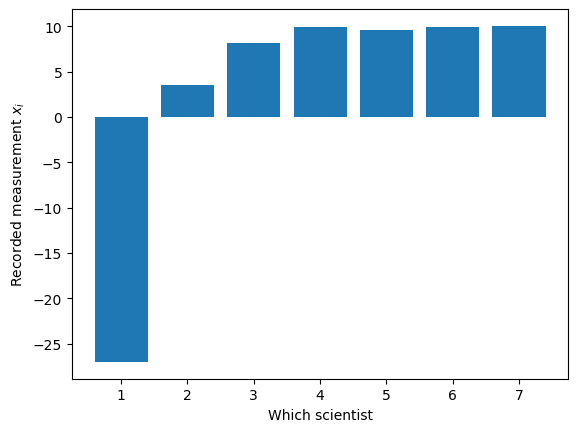

In [2]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


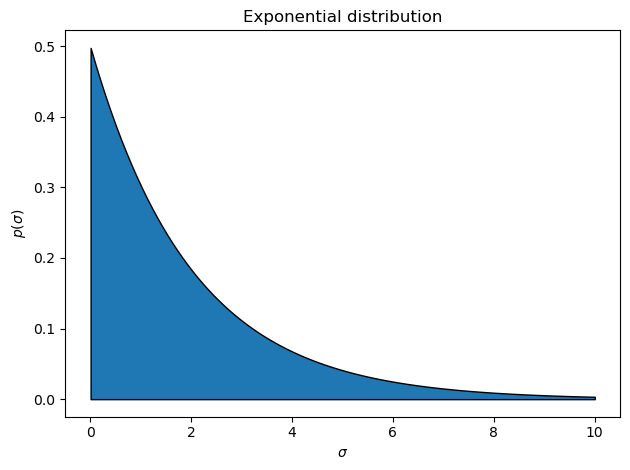

In [3]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");
plt.tight_layout()

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [110]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    if torch.any(sigma <= 0):
        return -np.inf

    log_prior_mu = dist.Normal(loc=0, scale=alpha, validate_args=False).log_prob(mu)
    log_prior_sigma = dist.Exponential(rate=beta).log_prob(sigma).sum(0)
    
    log_likelihood = torch.sum(torch.FloatTensor([dist.Normal(loc=mu, scale=sig).log_prob(xi) for sig, xi in zip(sigma, measurements)]) )
  

    return log_prior_mu + log_prior_sigma + log_likelihood


#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [111]:
# (GRADING)

In [112]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [262]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    assert sigma.shape == (7,)
    assert( torch.any(sigma > 0))
    assert(mu.shape == ()) 

    scale_sig = torch.tensor([1,0.7,0.2,0.18,0.2,0.2,0.25])
    q_sigma = dist.Normal(loc=sigma, scale= scale_sig)
    q_mu = dist.Normal(loc=mu, scale=0.3)
    
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [263]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
#del q_mu, q_sigma

In [436]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    new_mu = q_mu.sample()
    new_sigma = q_sigma.sample()

    p_new = log_joint(new_mu, new_sigma)
    p_old = log_joint(mu, sigma)

    if p_new - p_old > torch.rand(1).log().item():
        accepted = True
        return new_mu, new_sigma, accepted
    else:
        return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [437]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [646]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """   
    N_samples = 50000
    N_burnin = int(N_samples/4)
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [647]:

mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)

In [648]:
print(accepted)

0.25392


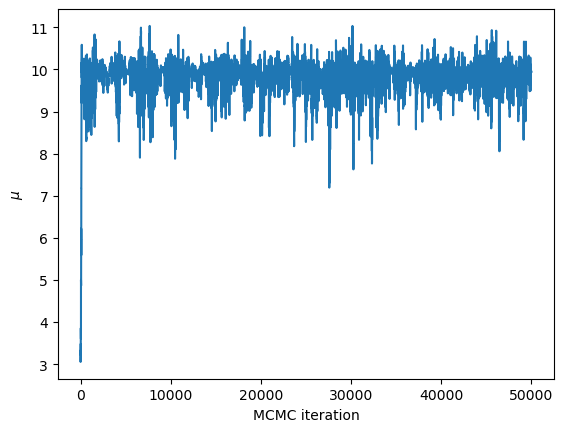

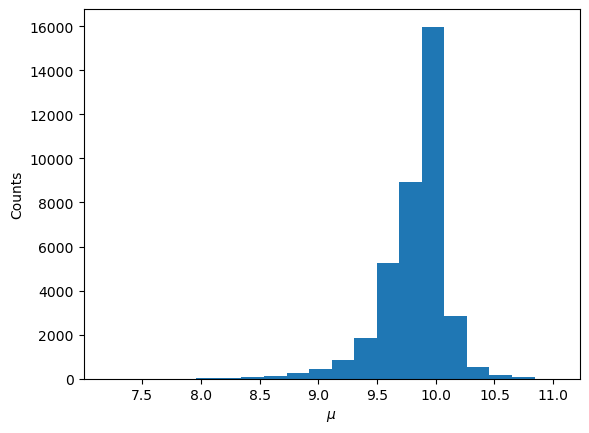

In [649]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

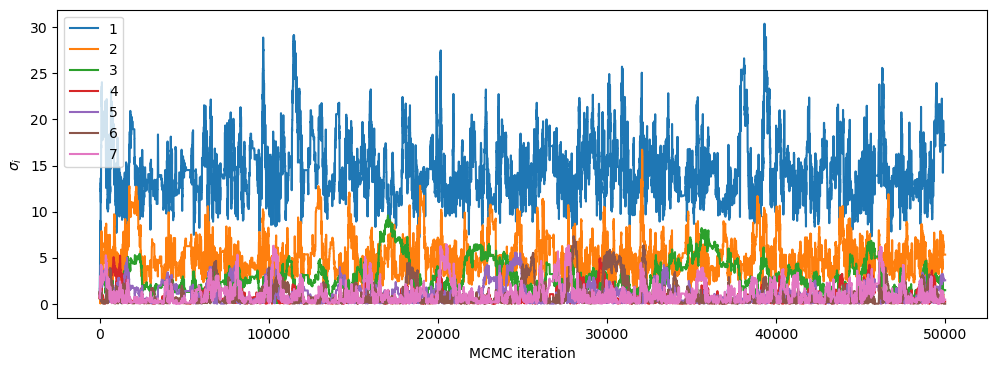

In [650]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

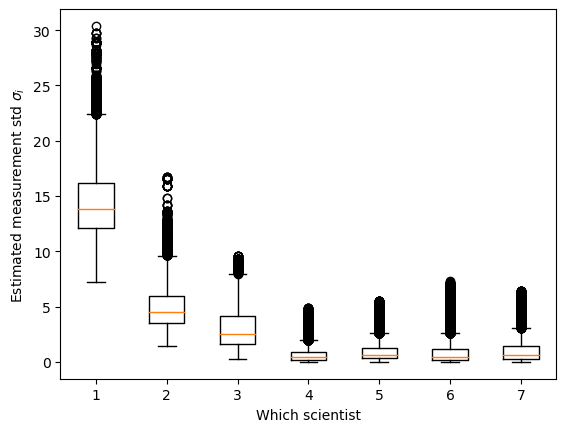

In [651]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [652]:
accepted

0.25392

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [653]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    return torch.mean(mu_chain[N_burnin:])
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    n_mu_less_than_9 = torch.sum(torch.where(mu_chain < 9, 1,0))
    n = len(mu_chain[N_burnin:])
    return n_mu_less_than_9 / n

In [654]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.8230
Pr(mu < 9) = 0.0318


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

**Q1:** 


For the proposal distributions, I chose a normal distribution for both distributions (univariate for $\mu$ and multivariate for $\sigma$) to 

1. Account for the symmetry needed in our accept-reject and 
2. The capability to explore the entire probability space of our target, even where the probability space still evaluates to zero. That is to avoid "getting stuck" before finding all the modes within the distribution. 

For the first case, the Gaussian distribution is symmetric, so it is equally likely to jump back or forth relative to our current state. That is, we are not biased toward the direction in the probability space we explore.

For the second point, the Gaussian is fortunately defined on the entire real line. Hence, the condition of exploring the entire probability space of our target distribution is satisfied. The accept-reject method reduces to; 

$$r = min(1, \frac{ p(x^{\dagger}) } { p(x) } )$$  
$$\text{as } q(x | x^{\dagger}) = q(x^{\dagger} | x)$$
 

Therefore, we the correction factor = 1. The probability ratio will ensure that *if* the probability of the new state is higher than the previous state, we definitely go to the new state based on our acceptance ratio. In that case, the proposals shifts modes to the newly estimated $\mu$ and $\sigma$ but keep their variances constant (to avoid large jumps if we find a high probable space). However, *if* the new state is *not as probable* as the previous state we might still make the jump depending on the relative probabilities (hence, the avoid "getting stuck" statement above).

Therefore, Gaussian as proposals satisfied the important criterions of symmetry and exploring the entire posterior probability space.
  
  
    
    

**Q2:**  

One weakness in high-dimensional problems is that when sampling n random variables at once, we can run into the issue that finding a suitable proposal is hard. Hence, a large proportion of our samples can get rejected. If we were to loop over each variable and sample independently from each other. Then, instead of having $\sigma$ as a multivariate distribution we could split it into univariates and sample one by one and perform updates at each separate iteration. If we were to do so, we assume that each scientist is independent of the other (which logically speaking is not a bad take). Hence, it is a feasible solution. However, we need to define proposals for each scientist. The efficiency would also depend on our proposals. If the global proposal is the true target then it suggests it would just add computational complexity and not contribute to a more efficient implementation. 

I would argue that in our case for the eight variables, presumably independent, we would not be likely to make it much more efficient with the element-wise updates. That is, as we would explore the same space for a longer time as it would be likely that we would sample from quite similar distribution but spend a much longer time iterating as we would have to iterate over each sample for every step. That is, as seen in the plots, the algorithm already seems to be doing quite a good job as it is. However, if we had a higher-dimensional case (say n=20) then one might consider changing the approach if we observe that the MCMC would have a high rejection rate.



#### Ignore the following cells. They are used by the grading system.

In [655]:
# (GRADING)

In [656]:
# (GRADING)

In [657]:
# (GRADING)

In [658]:
# (GRADING)

In [659]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [660]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """

    
    return dist.Uniform(0, 100,validate_args=False).log_prob(alpha) + dist.Uniform(0.01, 50, validate_args=False).log_prob(beta)



In [676]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    assert(sigma.shape == (7,))
    assert(mu.shape == ())
    accepted = False
    # scale beta = 7.4
    proposal_alpha = dist.Normal(loc=alpha,scale=6.5, validate_args=False).sample()
    
    proposal_beta = dist.Normal(loc=beta,scale=0.3, validate_args=False).sample()
    
    if proposal_alpha < 0 or proposal_beta < 0:
        return alpha, beta, accepted
        
    log_prior_new = log_prior_alpha_beta(proposal_alpha, proposal_beta)
    log_joint_new = log_joint(mu, sigma, proposal_alpha, proposal_beta)
    
    p_new = log_prior_new + log_joint_new
    
    log_joint_old = log_joint(mu, sigma, alpha, beta)
    log_prior_old = log_prior_alpha_beta(alpha, beta)

    p_old = log_joint_old + log_prior_old

    if (p_new - p_old) > torch.rand(1).log().item():
        accepted = True
        return proposal_alpha, proposal_beta, accepted
    
    else:
        return alpha, beta, accepted

### Run this MCMC algorithm, and plot the results.

#### What do you think?

**1. Are these results qualitatively different?**  
With respect to the distribution of $\mu$ in the MCMC, it is evident that the burn-in values roughly stay the same based on the pre-defined $\alpha$ and $\beta$ values provided. Hence, it does not seem as running a seperate MCMC step on $\alpha$ and $\beta$ provides large discrepencies to our estimation of $\mu$ and $\sigma$. However, this can depend on the chosen parameter space I have predefined for both. Based on the intuition that $\alpha$ corresponds to the standard deviation in $\mu$ and $\mu$ to the mean of our $x_{i} \text {'s}$ and $\beta$ to the variance of our $x_{i} \text {'s}$ it is fair to assume these values will not grow incredibly large. Even with a wider range for $\alpha$ and $\beta$ the resulting $\mu$ is still kept within the same range. Hence, they are not qualitatively very different.  

**2. Were the original choices of $\alpha, \beta$ reasonable?** 
  
  From the plots, it seems we over-estimate both. The average of $\alpha = 38.96...$ in the burn-in is within the 30-40 range. Hence, the initial value of $\alpha = 50$ exceeds that of the average from the MCMC average. Similarly, the average value of $\beta = 0.325...$ is less than the initial value of $\beta = 0.5$. Thus, both were overestimates initially relative to the MCMC averages.   
  

**3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?** 
  
Based on the output seen in the chains of estimating $\mu$ and $\sigma$ we can conclude that the results are not very sensitive to different values of $\alpha$ and $\beta$. That is, $\mu$ and $\sigma$ stay quite similar in the output from pre-defined values and optimized values of $\alpha$ and $\beta$. 

In [677]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)


In [678]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

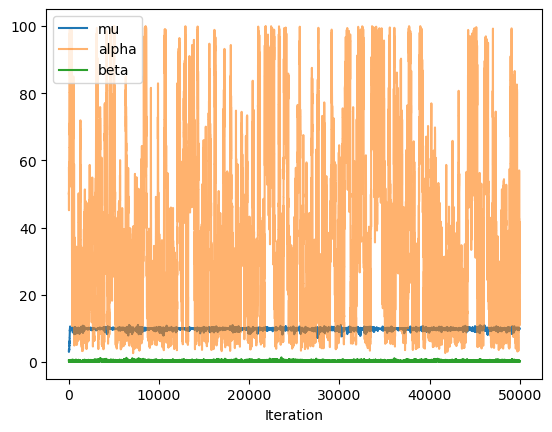

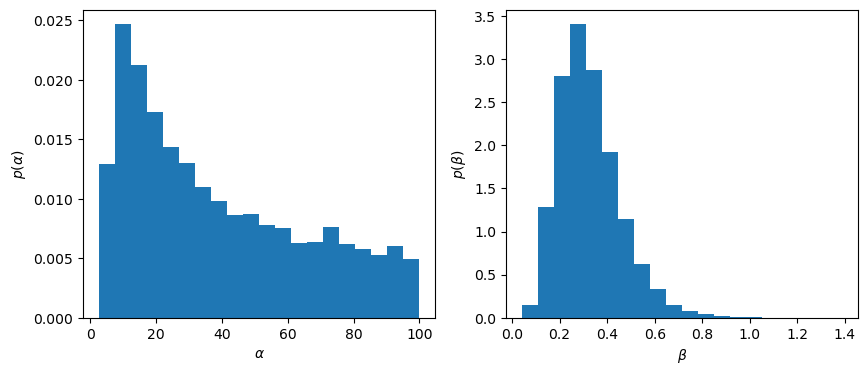

In [680]:
plt.plot(mu_chain)
plt.plot(alpha_chain, alpha=0.6);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

In [686]:
print(f" Beta average (MCMC) = {torch.mean(beta_chain[N_burnin:])}")
print(f" Alpha average (MCMC) = {torch.mean(alpha_chain[N_burnin:])}")

 Beta average (MCMC) = 0.3254932463169098
 Alpha average (MCMC) = 38.964332580566406


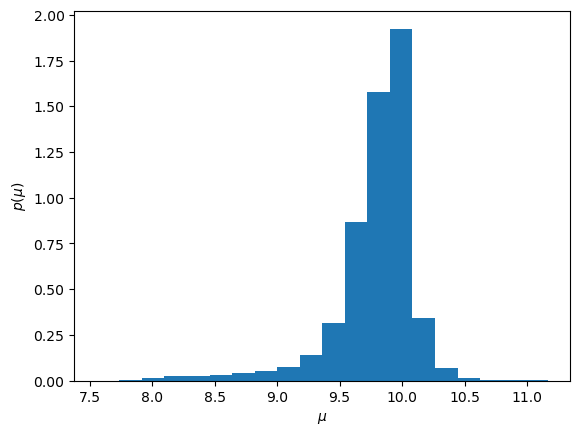

In [666]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

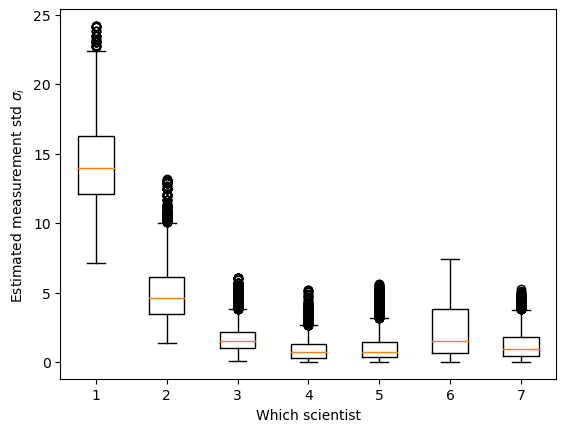

In [345]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)